<a href="https://www.kaggle.com/code/rubanzasilva/fastai-neural-network-gradient-boosting?scriptVersionId=187750416" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


In [2]:
!ls /kaggle/input/

playground-series-s4e7


In [3]:
!pip install catboost
!pip install optuna
!pip install optuna_distributed
!pip install openfe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.2 MB/s eta 0:00:00


In [4]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *


from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm
from ipywidgets import interact

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_auc_score,accuracy_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score



#transformers and pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv





import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
from optuna.samplers import TPESampler
import warnings


matplotlib.rc('image', cmap='Greys')

#from fastkaggle import setup_comp



from openfe import OpenFE, transform

#from IPython.display import FileLink

In [5]:
path = Path('/kaggle/input/playground-series-s4e7/')
path

Path('/kaggle/input/playground-series-s4e7')

In [6]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv')
#original_df = pd.read_csv('/kaggle/input/academic-success-dataset/data.csv',delimiter=';')

In [7]:
train_df.shape,test_df.shape

((11504798, 11), (7669866, 10))

## Subset

In [9]:
train_subset = train_df.sample(n=1000000,replace=False)
test_subset = test_df.sample(n=500000,replace=False)

In [10]:
train_subset.shape,test_subset.shape

((1000000, 11), (500000, 10))

In [11]:
train_subset.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
7438893,Female,66,1,28.0,0,1-2 Year,Yes,48674.0,124.0,106,0
9612814,Female,23,1,35.0,0,< 1 Year,No,27147.0,152.0,53,0
5402042,Male,51,1,15.0,0,1-2 Year,Yes,2630.0,157.0,96,0
10145156,Female,28,1,30.0,1,< 1 Year,No,30383.0,152.0,102,0
6872078,Female,46,1,8.0,0,1-2 Year,Yes,49121.0,124.0,94,0


In [7]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Response')
len(cat_names),len(cont_names)

(5, 5)

In [8]:
cont_names

['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

In [9]:
cat_names

['Gender',
 'Driving_License',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage']

In [10]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

In [11]:
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Response',
                   y_block=CategoryBlock(),
                   splits=splits)

In [12]:
to.xs.iloc[:2]

,Gender,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
9263544,2,2,1,1,2,0.574520,0.814670,0.436687,-1.598880,-0.749018
4553790,2,2,1,1,2,0.374448,0.121973,-1.690879,0.806515,-1.399178


In [13]:
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

In [14]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [16]:
dls.show_batch()

,Gender,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,1,0,< 1 Year,Yes,21.000001,26.000000,27735.000117,160.000001,101.999998,0
1,Female,1,1,< 1 Year,No,25.000000,15.000000,34245.000071,151.999999,206.000001,0
2,Male,1,1,< 1 Year,No,21.000001,45.000000,20256.000187,160.000001,121.000002,0
3,Female,1,1,< 1 Year,No,25.000000,40.999999,36317.999818,151.999999,145.000000,0
4,Male,1,1,< 1 Year,No,29.000000,15.000000,2629.999328,151.000001,261.999998,0
5,Female,1,0,1-2 Year,Yes,36.000000,42.999999,52834.999179,124.000000,126.000001,0
6,Male,1,0,1-2 Year,Yes,52.000000,40.999999,30403.000001,26.000003,200.999999,0
7,Female,1,1,< 1 Year,No,24.000000,28.000000,59800.999208,151.999999,31.000002,0
8,Male,1,1,< 1 Year,No,25.000000,40.999999,41792.999802,151.999999,128.000001,0
9,Female,1,1,< 1 Year,No,26.000000,28.000000,38078.999940,151.999999,158.000000,0


# Neural Network

In [21]:
learn = tabular_learner(dls, metrics=RocAucBinary())

SuggestedLRs(slide=0.019054606556892395, valley=0.0008317637839354575)

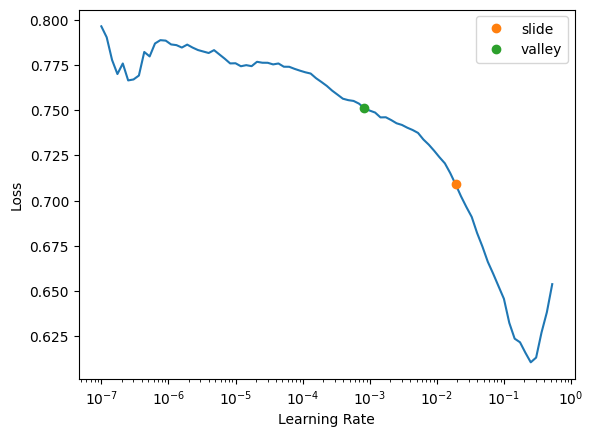

In [29]:
learn.lr_find(suggest_funcs=(slide,valley))

In [30]:
%%time
learn.fit_one_cycle(8,0.005)


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.270441,0.268346,0.853808,02:28
1,0.265915,0.267756,0.853531,02:24
2,0.266879,0.268468,0.855604,02:21
3,0.267903,0.268413,0.853962,02:23
4,0.266738,0.266122,0.855738,02:20
5,0.256359,0.265752,0.856621,02:26
6,0.268629,0.265090,0.857438,02:22
7,0.252085,0.264945,0.857652,02:26


CPU times: user 37min 4s, sys: 11.5 s, total: 37min 15s
Wall time: 19min 13s


In [ ]:
#target_preds = preds[0]
#targets =['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
#test_df[targets] = target_preds

#test_df.to_csv('submission.csv', columns=['id','Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'], index=False)

#sub = pd.read_csv('submission.csv')
#sub.head()

# Neural Network Ensemble

In [44]:
def ensemble():
    learn = tabular_learner(dls, metrics=RocAucMulti())
    with learn.no_bar(),learn.no_logging(): learn.fit(5, 0.005)
    return learn.get_preds(test_dl=test_dl)[0]

In [ ]:
learns = [ensemble() for _ in range(5)]

In [ ]:
ens_preds = torch.stack(learns).mean(0)

# Random Forest

In [58]:
%%time
rf = RandomForestClassifier(100, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

#mse = mean_absolute_error(y_test, rf_preds_x)
#rmse = np.sqrt(mse)

#accuracy_score(y_test,rf_preds_x)
roc_auc_score(y_test,rf_preds_x)

CPU times: user 1h 17min 53s, sys: 44 s, total: 1h 18min 37s
Wall time: 1h 18min 46s


0.5501960086555595

In [ ]:
#RandomForestClassifier??

# XGBoost

In [60]:
xgb_optuna_params = {
    'n_estimators': 929,
    'alpha': 2.287466581490129e-05,
    'subsample': 0.8766675651018592,
    'colsample_bytree': 0.288332829334817,
    'max_depth': 8,
    'min_child_weight': 6,
    'learning_rate': 0.024083411832750343,
    'gamma': 0.001816649055813574
}

In [17]:
xgb_model = xgb.XGBClassifier(n_estimators = 100, max_depth=8, learning_rate=0.1, subsample=0.5)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

#accuracy_score(y_test,xgb_preds_x)
xgb_score = roc_auc_score(y_test,xgb_preds_x)
xgb_score

0.5246763543042113

### Cross validation implementation

In [18]:
scores = cross_val_score(xgb_model,X_train, y_train,cv=5,scoring='roc_auc')
scores

array([0.87603466, 0.87641793, 0.8755647 , 0.87568598, 0.87514207])

In [19]:
scores.mean()

0.8757690680238108

In [18]:
xgb_score

0.5235608668840306

In [ ]:
xgb_model = xgb.XGBClassifier(alpha=0.2271025051979102,
                    gamma=0.07819541270693704,
                    eta=0.294535700691525,
                    max_depth=15,
                    max_bin=174857,
                    min_child_weight=1,
                    max_child_weight=10,
                    n_estimators=9500,
                    subsample=0.8362024536878123,
                    tree_method="hist",
                    device="cuda",
                    use_label_encoder=False,
                    enable_categorical=True,
                    eval_metric='auc',
                    objective='binary:logistic',
                    colsample_bytree=0.42784607351667425)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

#accuracy_score(y_test,xgb_preds_x)
xgb_score = roc_auc_score(y_test,xgb_preds_x)
xgb_score

# LightGBM

In [34]:
lgb_optuna_params =  {
    'num_leaves': 485, 
    'learning_rate': 0.016388605840878773, 
    'n_estimators': 1064, 
    'subsample_for_bin': 106545, 
    'min_child_samples': 382, 
    'reg_alpha': 4.355786683676367e-05, 
    'reg_lambda': 0.12174022484031638, 
    'colsample_bytree': 0.44894475300776, 
    'subsample': 0.735046656897411, 
    'max_depth': 8
}

In [35]:
lgb_model = lgb.LGBMClassifier(**lgb_optuna_params)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = roc_auc_score(y_test,lgb_preds_x)
lgb_score

[LightGBM] [Info] Number of positive: 98389, number of negative: 701611
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122986 -> initscore=-1.964450
[LightGBM] [Info] Start training from score -1.964450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

0.533750262042569

# CatBoost

In [36]:
cat_optuna_params = {
    
    'colsample_bylevel': 0.6383474716497279,
    'learning_rate': 0.09475494290429642,
    'random_strength': 0.07771221926568195,
    'max_bin': 490,
    'depth': 5,
    'l2_leaf_reg': 5,
    'boosting_type': 'Plain',
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.8429457747642737
    
}

In [37]:
%%time
cat_model = CatBoostClassifier(**cat_optuna_params)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))


#cat_preds_final = cat_preds.squeeze(1)

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

#cat_preds_x_final = cat_preds_x.squeeze(1)

#accuracy_score(y_test,cat_preds_x)

cat_score = roc_auc_score(y_test,cat_preds_x)
cat_score

CPU times: user 5min 23s, sys: 15.3 s, total: 5min 38s
Wall time: 2min


0.5348742009695298

# Model Predictions

In [39]:
model_preds = {
    "random forests":roc_auc_score(y_test,rf_preds_x),
    "cat boost":cat_score,
    "lgbm":lgb_score,
    "xgboost":roc_auc_score(y_test,xgb_preds_x),   
}

#model_preds_a = model_preds.sort()
print(model_preds)

{'random forests': 0.534829192513903, 'cat boost': 0.5348742009695298, 'lgbm': 0.533750262042569, 'xgboost': 0.5311687961499172}


In [41]:
cat_preds_x

tensor([0, 0, 0,  ..., 0, 0, 0])

# Model Ensemble

# Submission

In [21]:
!ls

In [22]:
submit = pd.read_csv(path/'sample_submission.csv')
submit.Response = xgb_preds
submit.to_csv('submission.csv',index=False)
submit

,id,Response
0,11504798,0
1,11504799,0
2,11504800,0
3,11504801,0
4,11504802,0
...,...,...
7669861,19174659,0
7669862,19174660,0
7669863,19174661,0
7669864,19174662,1


In [23]:
!ls

submission.csv


In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Response'] = xgb_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
sub